In [ ]:
import matplotlib.pyplot as plt
from skimage import io
import cv2
import numpy as np

In [ ]:
# function to show two images side by side
def plot_image(image_1, image_2, title_1="Image 1", title_2="Image 2"):
    plt.figure(figsize=(50, 50))
    plt.subplot(1, 2, 1)
    io.imshow(image_1)
    plt.title(title_1)
    plt.subplot(1, 2, 2)
    io.imshow(image_2)
    plt.title(title_2)
    plt.show()

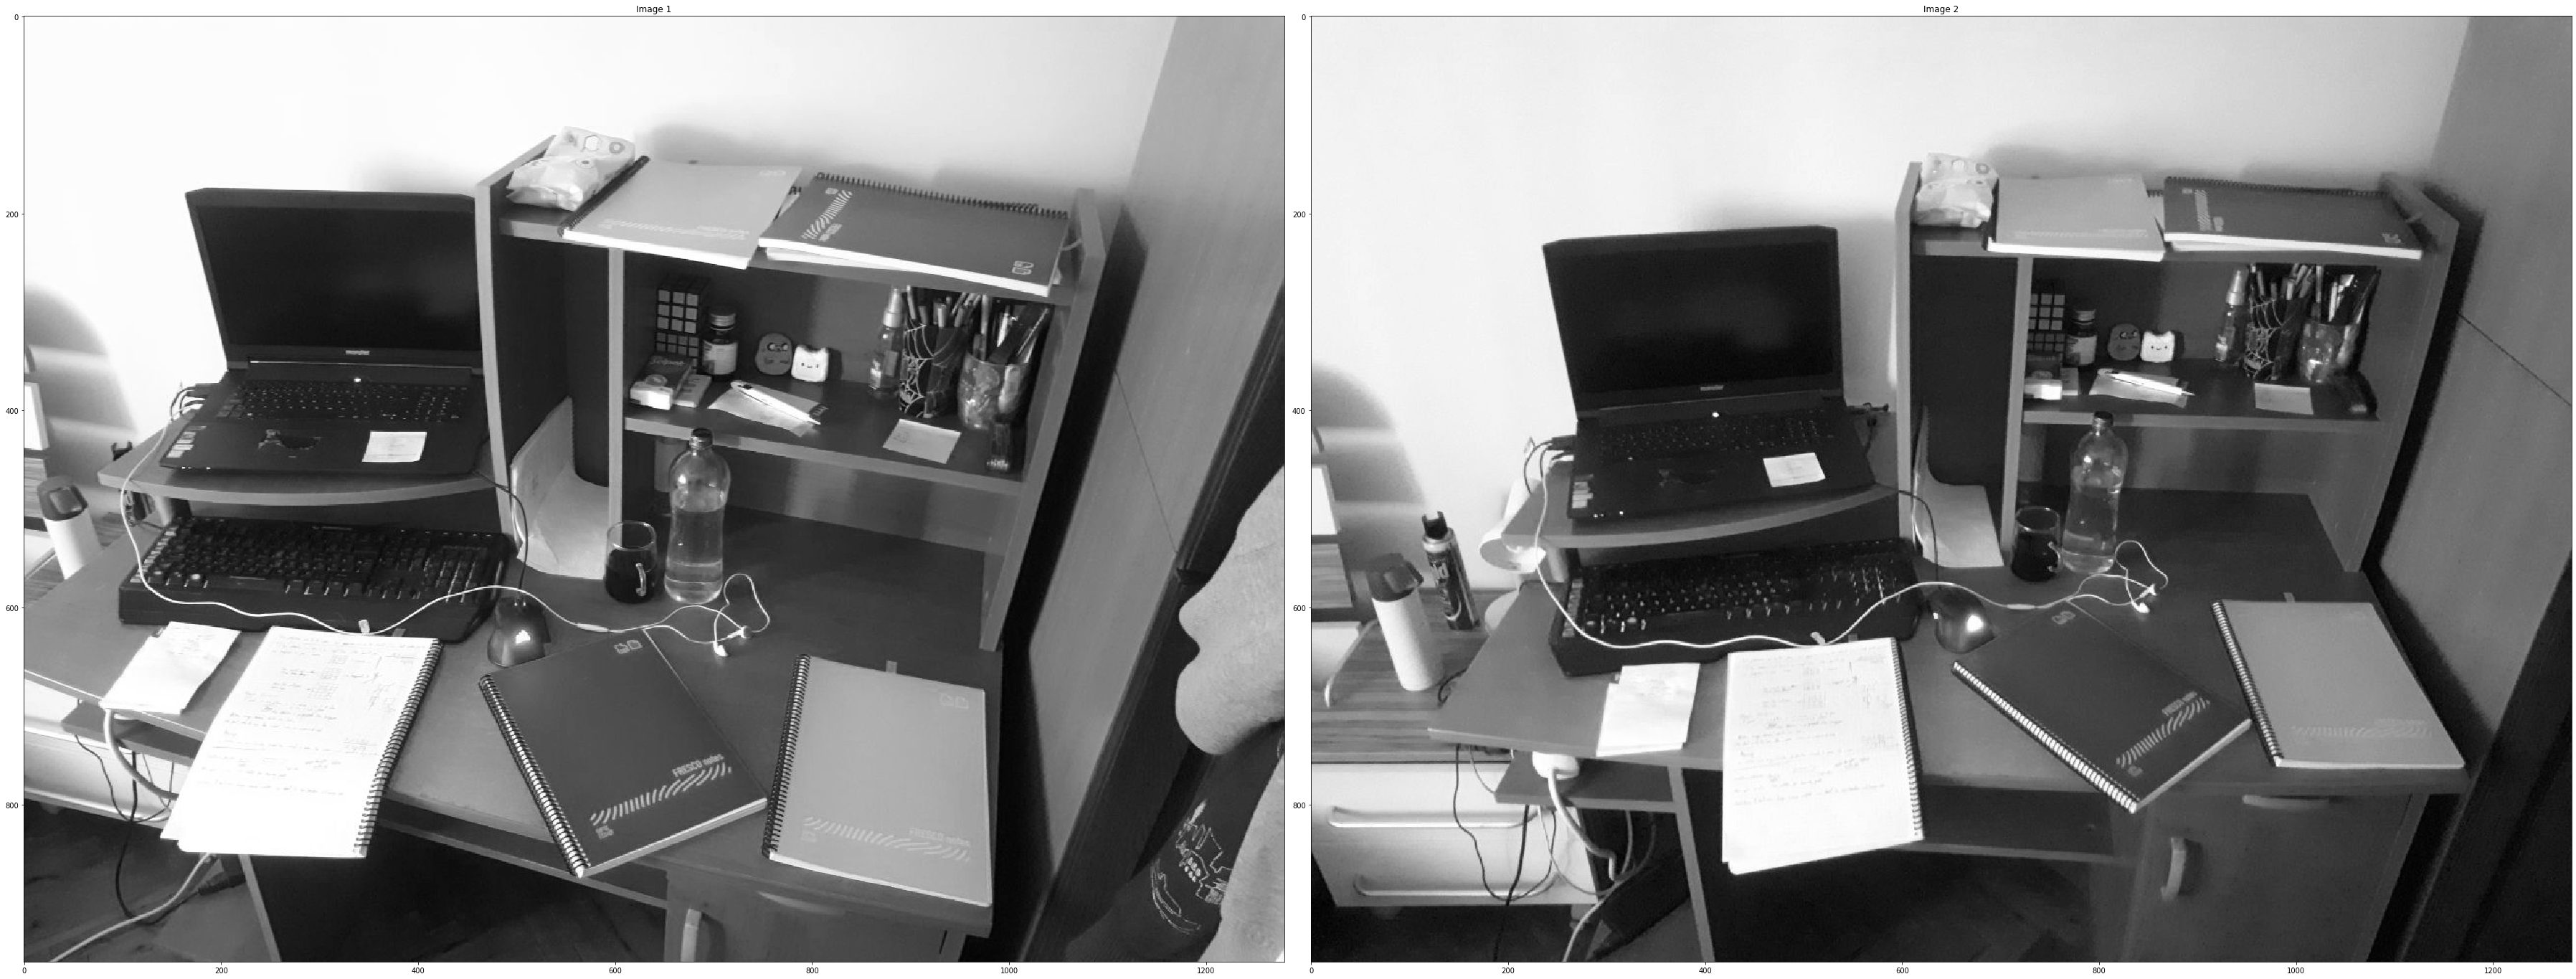

In [ ]:
image1_url = "https://github.com/kcyakici/CENG391-HW3-images/blob/main/edge_detection7.jpg?raw=true"
image2_url = "https://github.com/kcyakici/CENG391-HW3-images/blob/main/edge_detection8.jpg?raw=true"

image1 = io.imread(image1_url)
image2 = io.imread(image2_url)

image1_gray = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
image2_gray = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

plot_image(image1_gray, image2_gray)

Using the detectAndCompute function, I wanted to show the keypoints in both images first. Descriptors that are returned by this function will be used for keypoint matching.

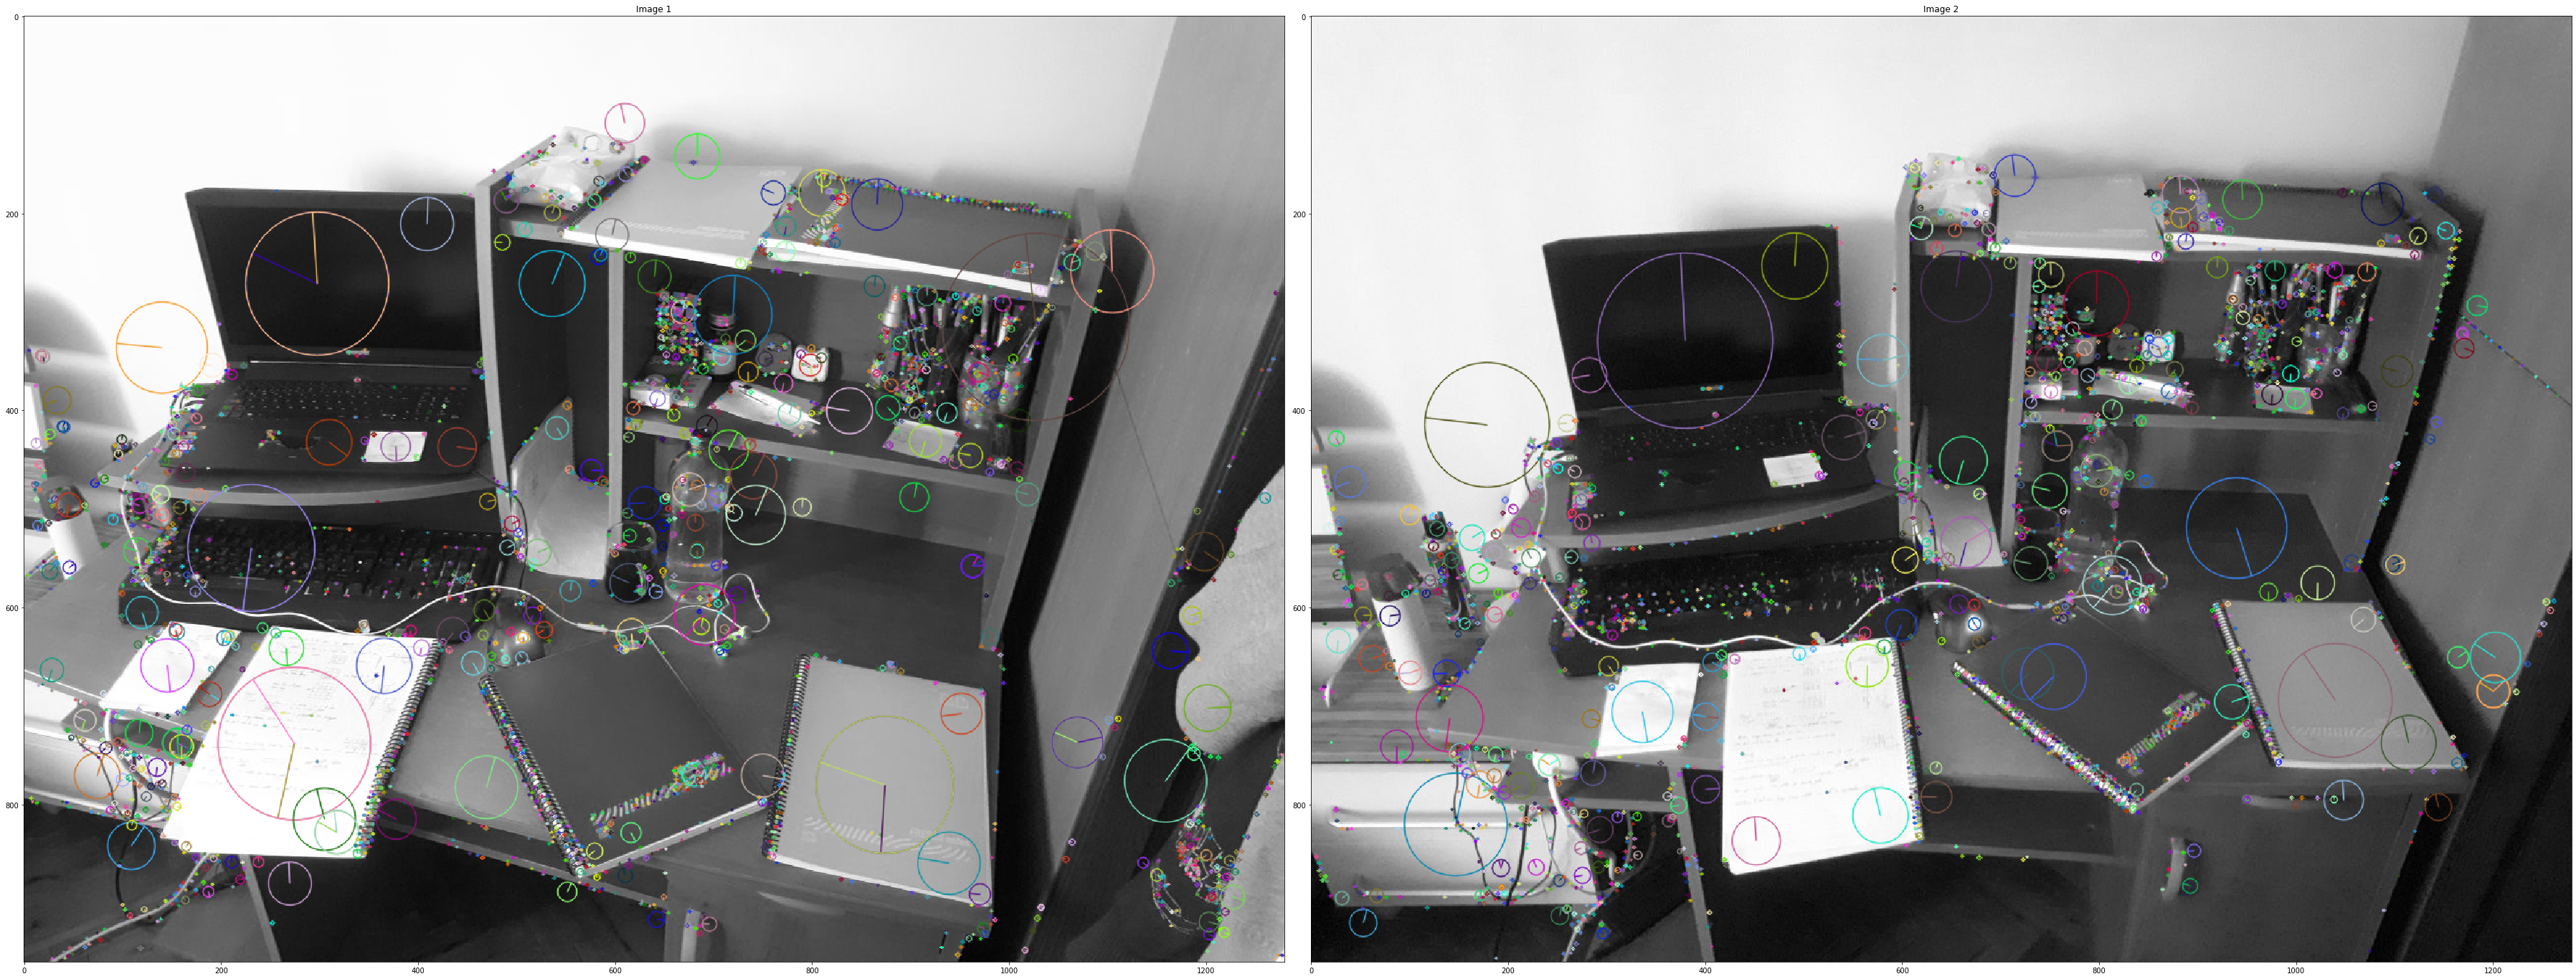

In [ ]:
sift = cv2.SIFT_create()

# get keypoints and descriptors from the images

keypoints_1, descriptors_1 = sift.detectAndCompute(image1_gray, None)
keypoints_2, descriptors_2 = sift.detectAndCompute(image2_gray, None)


image1_keyPoints = cv2.drawKeypoints(image1_gray, keypoints_1, image1,
                                     flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

image2_keyPoints = cv2.drawKeypoints(image2_gray, keypoints_2, image2,
                                     flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# draw the keypoints in the images
plot_image(image1_keyPoints, image2_keyPoints)

I first wanted to calculate the lengths of the descriptors in the second image seperately outside of the inner loop to save computing time.

In [ ]:
# calculate the lengths of the second array of descriptors to use in the for loop below
descriptor_lengths = list()
for descriptor in descriptors_2:
    squared_descriptor2 = np.square(descriptor)
    sum_of_elements2 = np.sum(squared_descriptor2)
    square_root2 = sum_of_elements2**(1/2)
    descriptor_lengths.append(square_root2)

Then I match the descriptors in the first image with the descriptors in the second image, I use the list above, in which I saved the lengths of the descriptors. These are needed for the cosine similarity calculations (denominator part of the equation)

In [ ]:
# after finding the lengths of the descriptors, use cosine similarity with the descriptors and find best two matches
# in the second image for every descriptor in the first image

good_descriptor_matches = list()
i = 0
for descriptor1 in descriptors_1:
    # initalize arrays to keep indices and similarities of matches
    # [index of first descriptor, index of second descriptor, cosine similarity]
    # if cosine similarity result is 0, vectors are perpendicular, if result is 1, they have the same angle
    # so if the result is closer to 1, this might be a good match
    # if they are close to one, that means they almost have the same angle
    first_good_match = [i, 0, -2]
    second_good_match = [i, 0, -2]

    # find descriptor length
    # square every element, sum them up, and take square root
    squared_descriptor1 = np.square(descriptor1)
    sum_of_elements1 = np.sum(squared_descriptor1)
    square_root1 = sum_of_elements1**(1/2)

    j = 0
    for descriptor2 in descriptors_2:
        # dot product of the matrices are required for the numerator part of the cosine similarity equation
        dot_product = np.matmul(descriptor1, descriptor2)

        cosine_similarity = dot_product / \
            (square_root1 * descriptor_lengths[j])

        if (second_good_match[2] < cosine_similarity):
            if first_good_match[2] < cosine_similarity:
                second_good_match[2] = first_good_match[2]
                second_good_match[1] = first_good_match[1]
                first_good_match[2] = cosine_similarity
                first_good_match[1] = j
            else:
                second_good_match[2] = cosine_similarity
                second_good_match[1] = j

        j += 1

    # put best two matches in a list and append to the bigger list
    first_two_good_matches = [first_good_match, second_good_match]
    good_descriptor_matches.append(first_two_good_matches)
    i += 1

In [ ]:
# use feature distance ratio
good = []
for descriptor_match1, descriptor_match2 in good_descriptor_matches:
    # f1 in feature distance ratio
    keypoint1 = keypoints_1[descriptor_match1[0]]
    # f2 in feature distance ratio
    keypoint2 = keypoints_2[descriptor_match1[1]]
    # f3 in feature distance ratio
    keypoint3 = keypoints_2[descriptor_match2[1]]
    # calculate Euclidian distances => hipotenuse
    distance1 = ((keypoint1.pt[1] - keypoint2.pt[1]) **
                 2 + (keypoint1.pt[0] - keypoint2.pt[0])**2)**(1/2)
    distance2 = ((keypoint1.pt[1] - keypoint3.pt[1]) **
                 2 + (keypoint1.pt[0] - keypoint3.pt[0])**2)**(1/2)
    # eliminate ambiguous points by setting a threshold = 0.12
    if distance1 < 0.12*distance2:
        good.append(descriptor_match1)

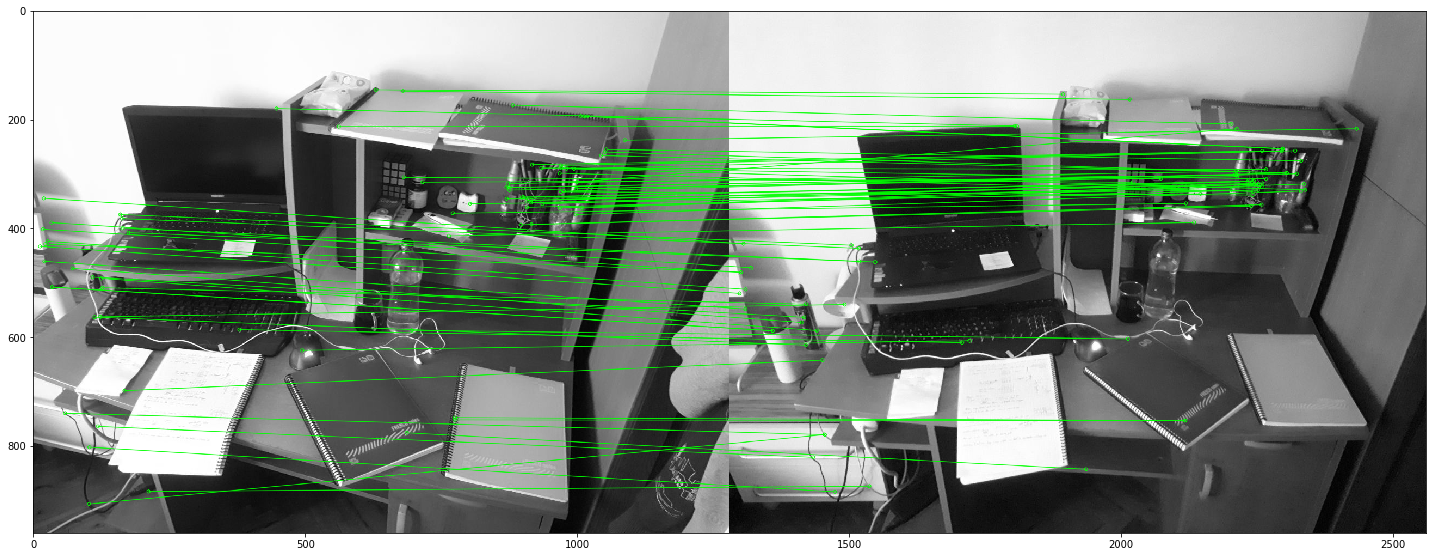

(<matplotlib.image.AxesImage at 0x7f0e81b14b10>, None)

In [ ]:
draw_params = dict(matchColor=(0, 255, 0),  # draw matches in green color
                   singlePointColor=None,
                   flags=2)

# create an array of dMatch objects for good matches to use plug into drawMatches()
dMatch_object_list = list()
for good_match in good:
    dMatch_object_list.append(cv2.DMatch(good_match[0], good_match[1], 1, 0))

img3 = cv2.drawMatches(image1_gray, keypoints_1, image2_gray,
                       keypoints_2, dMatch_object_list, None, **draw_params)
plt.figure(figsize=(20, 20))
io.imshow(img3), plt.show()

# With different thresholds, 0.15

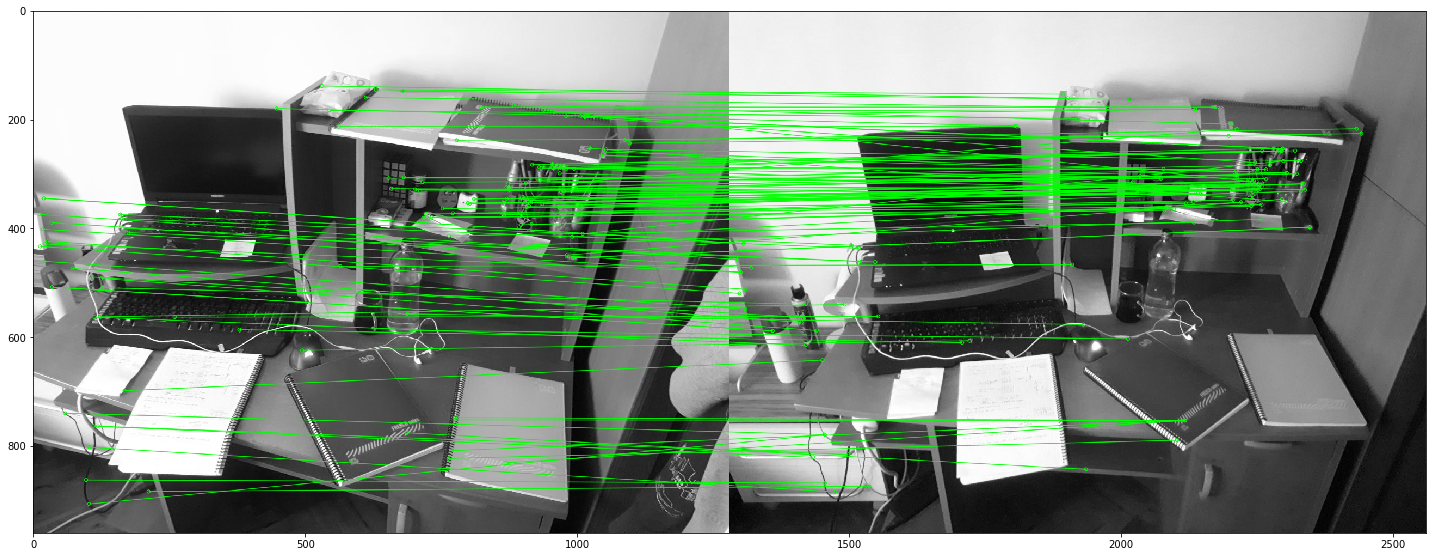

(<matplotlib.image.AxesImage at 0x7f0e815dc650>, None)

In [ ]:
# use feature distance ratio
good = []
for descriptor_match1, descriptor_match2 in good_descriptor_matches:
    # f1 in feature distance ratio
    keypoint1 = keypoints_1[descriptor_match1[0]]
    # f2 in feature distance ratio
    keypoint2 = keypoints_2[descriptor_match1[1]]
    # f3 in feature distance ratio
    keypoint3 = keypoints_2[descriptor_match2[1]]
    # calculate Euclidian distances => hipotenuse
    distance1 = ((keypoint1.pt[1] - keypoint2.pt[1]) **
                 2 + (keypoint1.pt[0] - keypoint2.pt[0])**2)**(1/2)
    distance2 = ((keypoint1.pt[1] - keypoint3.pt[1]) **
                 2 + (keypoint1.pt[0] - keypoint3.pt[0])**2)**(1/2)
    # eliminate ambiguous points by setting a threshold = 0.15
    if distance1 < 0.15*distance2:
        good.append(descriptor_match1)

draw_params = dict(matchColor=(0, 255, 0),  # draw matches in green color
                   singlePointColor=None,
                   flags=2)

# create an array of dMatch objects for good matches to use plug into drawMatches()
dMatch_object_list = list()
for good_match in good:
    dMatch_object_list.append(cv2.DMatch(good_match[0], good_match[1], 1, 0))

img3 = cv2.drawMatches(image1_gray, keypoints_1, image2_gray,
                       keypoints_2, dMatch_object_list, None, **draw_params)
plt.figure(figsize=(20, 20))
io.imshow(img3), plt.show()

# With different thresholds, 0.10

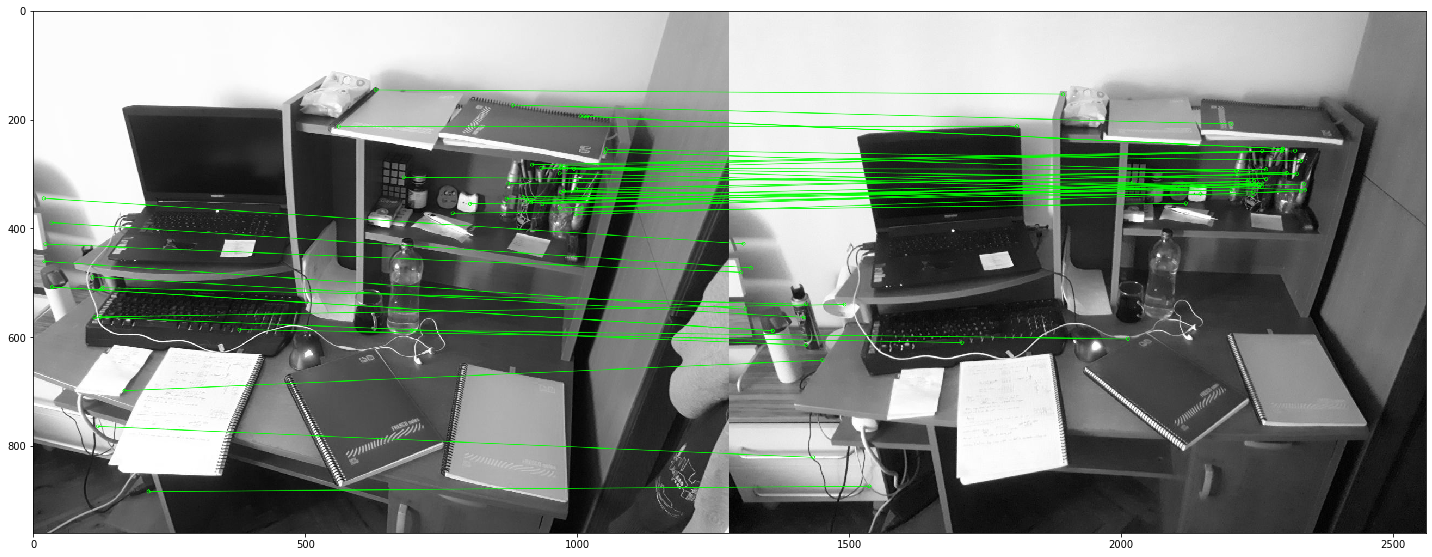

(<matplotlib.image.AxesImage at 0x7f0e815bced0>, None)

In [ ]:
# use feature distance ratio
good = []
for descriptor_match1, descriptor_match2 in good_descriptor_matches:
    # f1 in feature distance ratio
    keypoint1 = keypoints_1[descriptor_match1[0]]
    # f2 in feature distance ratio
    keypoint2 = keypoints_2[descriptor_match1[1]]
    # f3 in feature distance ratio
    keypoint3 = keypoints_2[descriptor_match2[1]]
    # calculate Euclidian distances => hipotenuse
    distance1 = ((keypoint1.pt[1] - keypoint2.pt[1]) **
                 2 + (keypoint1.pt[0] - keypoint2.pt[0])**2)**(1/2)
    distance2 = ((keypoint1.pt[1] - keypoint3.pt[1]) **
                 2 + (keypoint1.pt[0] - keypoint3.pt[0])**2)**(1/2)
    # eliminate ambiguous points by setting a threshold = 0.10
    if distance1 < 0.10*distance2:
        good.append(descriptor_match1)


draw_params = dict(matchColor=(0, 255, 0),  # draw matches in green color
                   singlePointColor=None,
                   flags=2)

# create an array of dMatch objects for good matches to use plug into drawMatches()
dMatch_object_list = list()
for good_match in good:
    dMatch_object_list.append(cv2.DMatch(good_match[0], good_match[1], 1, 0))

img3 = cv2.drawMatches(image1_gray, keypoints_1, image2_gray,
                       keypoints_2, dMatch_object_list, None, **draw_params)
plt.figure(figsize=(20, 20))
io.imshow(img3), plt.show()

I believe the errors that are happening are because:


*   The exact keypoints are not present in both images, so when we use the cosine similarity, best match in the existing keypoints are used even if the points are irrelevant.
*   The image rotation may affect the results
* By using cosine similarity, we only match the points that have a similar gradient direction and magnitude, however, the positions of the keypoints are not guaranteed. Two different points may have the same gradient characteristics but may be on different areas, yet, they will be matched.



